# Лабораторная работа 4 -- Поиск нечетких дубликатов (каво)

## Задание 1.

Выбираем тексовую коллекцию

# Задание 2.

Устанавливаем то, что и так уже установлено, спасибо моему диплому

# Задание 3.

Вычленить из него и культивировать затем я собираюсь это
Вычленить из нее и культивировать затем я тоже собираюсь это

Почитал, преисполнился, понял, что ничего не понял.
Попробую сделать в такой последовательности:
1. Достаем документы, канонизируем каждый
2. У нас массив сообщений, каждое разбиваем на шинглы (пусть размер будет 3, у меня маленькие сообщения временами)
3. Создаем матрицу схожести, с помощью fuzzywuzzy пытаемся определить средний процент схожести по шинглам и... Что-нибудь интересное получаем
4. Пихаем это в иерархическую кластеризацию, попробуем посмотреть дендрограмму
5. Увольняюсь и иду работать сварщиком

Пожалуй, свой датасет я даже урежу, чтобы можно было посмотреть на это дело глазками.

In [20]:
import pandas as pd

data = pd.read_csv("shuffled.csv", nrows=50)

In [27]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, tokenizer.tokenize(str(sentences)))))

documents = data['text'].apply(lambda x: getClearSentences(x))
non_affected_documents = data.copy()
documents

0                          ну ебать завтра день радость
1     ещё год назад потерять сам близкий человек сож...
2     ой любить есть ты хотеться что сладкое вредный...
3     общий любой непонятный ситуация кидать подруга чс
4                  сегодня закончиться я мочь я уходить
5          любой случай аой солнышко девочка данганронп
6     а 31 хотеть жить ребёнок муж постоянно работа ...
7     о женя красивый имя это ник разница всё равно ...
8                                  брат встретиться оам
9     почему твиттер говорить мочь посмотреть твит н...
10    помочь мой мать постоянно давить ссориться вре...
11    перестать чувствовать ничтожество хотеть прост...
12    блядь наверное скоро начать выпивать съёмка ст...
13    по логика ходить беременный вести блядь дневни...
14    я уровень умирать хотеться жить прекрасный реш...
15    свой проблема переживание я бояться написать п...
16    больно делать человек очень тяжело жить нести ...
17                добрый ночь найти poðstilka mu

Вы бы знали, как я скакал от счастья, когда узнал, что шинглировать можно через nltk..

In [28]:
SHINGLE_LEN = 3

from nltk.util import ngrams

shingles = []

for i in range(0, len(documents)):
    shingles.append(list(map(list, ngrams(nltk.word_tokenize(documents[i]), SHINGLE_LEN))))

In [29]:
import numpy as np
from thefuzz import fuzz

similarity_matrix = np.zeros((len(documents), len(documents)))

for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        shingles_i = shingles[i]
        shingles_j = shingles[j]
        # мама, памагити
        shingle_similarities = [fuzz.ratio(shingle_i, shingle_j) for shingle_i in shingles_i for shingle_j in shingles_j]
        similarity = np.mean(shingle_similarities)
        
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

In [30]:
similarity_matrix_rounded = np.round(similarity_matrix, 2)

df = pd.DataFrame(similarity_matrix_rounded, columns=range(len(shingles)), index=range(len(shingles)))

print(df)

      0     1     2     3      4     5     6     7    8     9   ...    40  \
0   0.00  1.74  0.00  0.00   0.00  0.00  1.83  0.00  0.0  0.00  ...  0.00   
1   1.74  0.00  1.80  0.00   1.52  0.00  0.69  0.90  0.0  2.12  ...  1.07   
2   0.00  1.80  0.00  0.00   0.00  0.00  1.27  3.51  0.0  0.00  ...  0.90   
3   0.00  0.00  0.00  0.00   0.00  3.30  0.00  0.00  0.0  0.00  ...  0.00   
4   0.00  1.52  0.00  0.00   0.00  0.00  2.75  0.00  0.0  9.28  ...  3.40   
5   0.00  0.00  0.00  3.30   0.00  0.00  0.00  0.00  0.0  0.00  ...  0.00   
6   1.83  0.69  1.27  0.00   2.75  0.00  0.00  0.63  0.0  0.00  ...  1.33   
7   0.00  0.90  3.51  0.00   0.00  0.00  0.63  0.00  0.0  0.00  ...  0.67   
8   0.00  0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.0  0.00  ...  0.00   
9   0.00  2.12  0.00  0.00   9.28  0.00  0.00  0.00  0.0  0.00  ...  0.36   
10  0.00  1.18  0.91  0.00   1.48  0.00  1.15  0.39  0.0  0.95  ...  0.80   
11  0.00  1.45  0.00  0.00   0.00  0.00  0.92  0.00  0.0  4.12  ...  0.97   

#### Штош. Можно уверенно сказать, что дубликатов-дубликатов прямо нет, однако мы можем сказать, что, пущай для нас дубликат -- это всё, что имеет процент выше 15% схожести))

In [31]:
import numpy as np

# set the similarity threshold
threshold = 15

# find pairs of messages with a similarity score above the threshold
for i in range(len(shingles)):
    for j in range(i+1, len(shingles)):
        if similarity_matrix[i][j] >= threshold:
            print("Сообщения \n " + documents[i] + "\n" + documents[j] + f" \n похожи на {similarity_matrix[i][j]:.2f}")

Сообщения 
 сегодня закончиться я мочь я уходить
свой проблема переживание я бояться написать просто поговорить мочь показаться нытик мочь надоесть я хотеть наш общение прекращаться слишком закомплексованный простить показаться ужасный 
 похожи на 16.13
Сообщения 
 сегодня закончиться я мочь я уходить
я собираться отправиться ад я знать заслужить это 
 похожи на 22.00
Сообщения 
 сегодня закончиться я мочь я уходить
я раздражать абсолютно всё 
 похожи на 16.50
Сообщения 
 по логика ходить беременный вести блядь дневник охуеть
хотеть работа ходить 
 похожи на 16.50


### Я, конечно, немного офигел, как он считает "похожесть", потому что на примерах -- это одно, а тут как-то все странно выглядит... Но дарёному коню в зубы не смотрят, особенно, если ты цыган, поэтому ОЧЕНЬ хочется заметить, что суицидальные сообщения внезапно похожи :)

Ну, воспользуемся ради прикола иерархической кластеризацией и получим...

КлАсТеР 1:
Ну все ебать!!! Завтра день радости будет!!!
Ещё два года назад я потеряла самого близкого себе человека, к сожалению это очень сильно отобразилось на мое психические состояния, сейчас я живу суицидом, каждый день две-три попытки, почему то безуспешны, этому бывают разные причины на самом деле, где бы я не пыталась свести счеты с жизнью всегда что то мешало... послейднее время я стала задумываться о смысле жизни, скажу так многое стало меня даже пугать, меня стали пугать сами люди и то что происходит в мире каждый день, я уже не знаю что делать честно говоря, единственное что меня отвлекает это чтение книг, когда я это делаю прям все мысли не те уходят, но не могу же я всю жизнь провести в книгах....можно совет? Честно не хочу этого всего, я хочу что бы этот кошмар закончился как и эти мысли.....
Ой, еще люблю, когда ешь что-то, что тебе хочется. Что-то сладкое или вредное, да даже если это диетические продукты все орут, что это не еда блять
в общем в любой непонятной ситуац

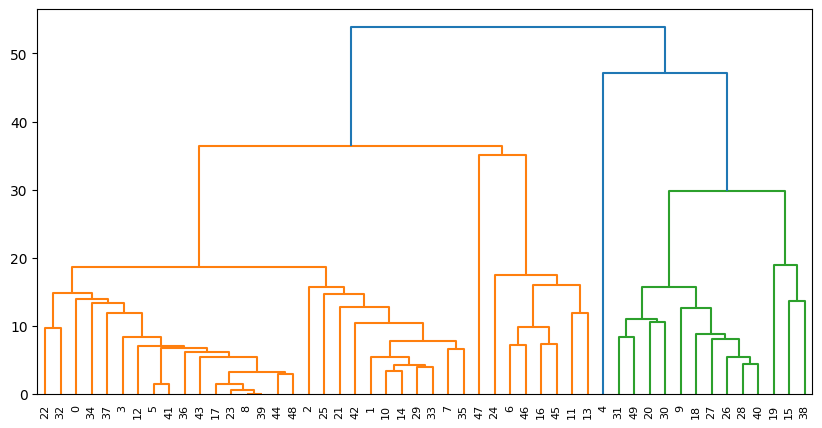

In [34]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage

# convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix

# perform HAC using Ward's method
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# plot the dendrogram
fig = plt.figure(figsize=(10, 5))
dn = sch.dendrogram(linkage_matrix)

clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
for i in range(1, len(set(clusters)) + 1):
    print(f'КлАсТеР {i}:')
    cluster_messages = [non_affected_documents['text'][j] for j, c in enumerate(clusters) if c == i]
    for message in cluster_messages:
        print(message)
    print("\n")



Итого получаем очень крутую дендрограмму, мне прям нраица.

И посмотрим на кластеры! Кластеры, которые нас разочаруют! Вуху! Но вообще заметны потуги как-то отделить что-то более-менее суицидальное, но больше похоже, что дележка по итогу пошла по настроениям. Так или иначе, если подкрутить, дать это DBSCAN, попробовать какие-нибудь еще Гат-Гева и прочее, можно, наверное, получить хорошие результаты. Но это уже оставим на будущие научные работы...
